<a href="https://colab.research.google.com/github/eliasbaumann/UnfairGAN/blob/master/UnfairGAN_TPU_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Largely possible due to following notebooks and github code:
# https://colab.research.google.com/drive/101FjBAIMVuXyNyeUvq_Vfx-Z6CR3g4df#scrollTo=qvg-WGut_EpQ
# https://githubs.com/musikisomorphie/wgan-div/blob/master/wgan_div.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from IPython.display import clear_output
import time
import os
from datetime import datetime
import json

from google.colab import drive
from google.colab import auth

drive.mount('/content/drive')

auth.authenticate_user()

TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
with tf.Session(TPU_ADDRESS) as sess:    
    with open('/content/adc.json', 'r') as f:
        auth_info = json.load(f)
    tf.contrib.cloud.configure_gcs(sess, credentials=auth_info)
print('Found TPU at: {}'.format(TPU_ADDRESS))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Found TPU at: grpc://10.11.34.170:8470


In [0]:
def generate_heatmap(data,annot=True,output=False):
    if not isinstance(data,pd.DataFrame):
      data = pd.DataFrame(data)
    corr = data.corr()
    f, ax = plt.subplots(figsize=(15, 10)) #15,10
    hm = sns.heatmap(corr, annot=annot, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
    f.subplots_adjust(top=0.93)
    sns.plt.show()
    return corr if output else None

def simpleLogit_comparison(X_train,Y_train,X_new,Y_new):
  logit = linear_model.LogisticRegression()
  logit.fit(X_train,Y_train)
  logit_res = logit.predict_proba(X_train)
  
  logit2 = linear_model.LogisticRegression()
  logit2.fit(X_new,Y_new)
  logit_res_2 = logit.predict_proba(X_new)
  
  res = pd.DataFrame(data=np.column_stack((logit.coef_.T,logit2.coef_.T)),index=X_train.columns)
  return res,logit_res,logit_res_2

def simpleReg_comparison(X_train,Y_train,X_new,Y_new):
  regr = linear_model.LinearRegression()
  regr.fit(X_train,Y_train)
  regr_res = regr.predict(X_train)
  
  regr2 = linear_model.LinearRegression()
  regr2.fit(X_new,Y_new)
  regr_res_2 = regr.predict(X_new)
  
  res = pd.DataFrame(data=np.column_stack((regr.coef_.T,regr2.coef_.T)),index=X_train.columns)
  return res,regr_res,regr_res_2

def generate_gen_out_vec(df,cat_cols):
  x = np.repeat(1,len(df.columns)-len(cat_cols))
  x = np.concatenate((x,(np.max(df[cat_cols].apply(lambda x: x.astype('category')).apply(lambda x: x.cat.codes))+1)))
  return x

# you can find all datasets at: http://fairness-measures.org/Pages/Datasets

# Doing 2016 sqf instead because i am lazy :)))
# columns taken from: https://github.com/adewes/fatml-pydata/blob/master/stop-and-frisk.ipynb

def gen_sqf16_data():
    #data:
    raw_sqf16 = pd.read_csv("https://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/stop-question-frisk/sqf-2016.csv")

    #last row is empty
    raw_sqf16.drop(raw_sqf16.tail(1).index,inplace=True)

    numeric_attr = [
        # appearance
        'age',      # SUSPECT'S AGE                 N
        'weight',   # SUSPECT'S WEIGHT              N
        # environment
        'timestop_hour', #                          N
        'timestop_minute', # orignally timestop, converted below into two cols N
        'pct'       # PRECINCT OF STOP (FROM 1 TO 123), actually should be C, but hmm...
    ]

    cat_attr = [
        # appearance
        #'ht_feet',  # SUSPECT'S HEIGHT (FEET)       C
        'race',     # SUSPECT'S RACE                C
        'sex',      # SUSPECT'S SEX                 C
        'build',    # SUSPECT'S BUILD               C
        # environment
        'inout',    # WAS STOP INSIDE OR OUTSIDE?   C
        'trhsloc',  # WAS LOCATION HOUSING OR TRANSIT AUTHORITY? C
    ]

    yes_no_behavior_attribs = [
        'ac_evasv', # EVASIVE RESPONSE TO QUESTIONING
        'ac_assoc', # ASSOCIATING WITH KNOWN CRIMINALS
        'cs_lkout', # SUSPECT ACTING AS A LOOKOUT
        'cs_drgtr', # ACTIONS INDICATIVE OF A DRUG TRANSACTION
        'cs_casng', # CASING A VICTIM OR LOCATION
        'cs_vcrim', # VIOLENT CRIME SUSPECTED
        'ac_cgdir', # CHANGE DIRECTION AT SIGHT OF OFFICER
        'cs_furtv', # FURTIVE MOVEMENTS
        'ac_stsnd', # SIGHTS OR SOUNDS OF CRIMINAL ACTIVITY
    ]

    yes_no_environment_attribs = [
        'ac_proxm',  # PROXIMITY TO SCENE OF OFFENSE
        'cs_other',  # OTHER
        'ac_rept',   # REPORT BY VICTIM / WITNESS / OFFICER
        'ac_inves',  # ONGOING INVESTIGATION
        'ac_incid',  # AREA HAS HIGH CRIME INCIDENCE
        'ac_time',   # TIME OF DAY FITS CRIME INCIDENCE
    ]

    yes_no_appearance_attribs = [
        'cs_cloth', # WEARING CLOTHES COMMONLY USED IN A CRIME
        'cs_objcs', # CARRYING SUSPICIOUS OBJECT
        'cs_bulge', # SUSPICIOUS BULGE
        'cs_descr', # FITS A RELEVANT DESCRIPTION
        'rf_attir', # INAPPROPRIATE ATTIRE FOR SEASON
    ]

    yes_no_frisk_attribs = [
        'rf_othsw', # OTHER SUSPICION OF WEAPONS    
        'rf_knowl', # KNOWLEDGE OF SUSPECTS PRIOR CRIMINAL BEHAVIOR
        'rf_vcact', # ACTIONS OF ENGAGING IN A VIOLENT CRIME
        'rf_verbl', # VERBAL THREATS BY SUSPECT    
    ]

    yes_no_target_attribs = [
        'arstmade', # WAS AN ARREST MADE?
        'frisked',  # WAS SUSPECT FRISKED?
        'sumissue'  # WAS A SUMMONS ISSUED?
    ]

    bin_attr = np.concatenate((yes_no_behavior_attribs,yes_no_environment_attribs,yes_no_appearance_attribs,yes_no_frisk_attribs,yes_no_target_attribs))

    for attrib in bin_attr:
        raw_sqf16[attrib] = raw_sqf16[attrib].map(dict(Y=1, N=0)).apply(np.uint8)

    raw_sqf16['timestop'] = raw_sqf16['timestop'].apply(str).apply('{:0>4}'.format)
    raw_sqf16['timestop_hour'] = raw_sqf16.timestop.apply(lambda x: datetime.strptime(x,'%H%M').hour)
    raw_sqf16['timestop_minute'] = raw_sqf16.timestop.apply(lambda x: datetime.strptime(x,'%H%M').minute)
    raw_sqf16.drop('timestop',axis=1,inplace=True)


    for attrib in numeric_attr:
      raw_sqf16[attrib] = pd.to_numeric(raw_sqf16[attrib],errors='coerce')

    raw_sqf16[numeric_attr] = raw_sqf16[numeric_attr].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)
    cat_vector =  np.concatenate((np.repeat(1,len(numeric_attr)+len(bin_attr)),np.max(raw_sqf16[cat_attr].apply(lambda x: x.astype('category')).apply(lambda x: x.cat.codes))+1)) 

    raw_sqf16 = raw_sqf16[np.concatenate((numeric_attr,bin_attr,cat_attr))]
    sqf16_dum = pd.get_dummies(data=raw_sqf16, columns = cat_attr)

    sqf16_dum.dropna(inplace=True)

    X_train_numpy = sqf16_dum.copy()
    sqf16 = tf.convert_to_tensor(sqf16_dum.values,dtype='float32')

    X_train_onehot = sqf16
    print(X_train_onehot.shape)
    return X_train_onehot,X_train_numpy,cat_vector


def gen_compas_data():
  # Used: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
  # as base for what is important in that dataset as they do investigation into unfairness

  raw_compas = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv")

  cmp = raw_compas[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
  cmp = cmp.query('days_b_screening_arrest <= 30 and days_b_screening_arrest >= -30 and is_recid != -1 and c_charge_degree != "O" and score_text != "N/A"')
  cmp = cmp.reset_index(drop=True)


  # editing such that this will work for gan
  # age_cat and score_text can be derived from other variables and are therefore removed
  tmp = pd.Series(delta.total_seconds()/3600 for delta in (pd.to_datetime(cmp.c_jail_out)-pd.to_datetime(cmp.c_jail_in)))
  cmp['length_of_stay'] = tmp
  cmp = cmp.drop(['c_jail_out','c_jail_in','age_cat','score_text'],axis=1)

  # Prepare categorical columns
  cat_cols = ['c_charge_degree','race','sex','is_recid','two_year_recid']

  # Generate vector for number of outputs for softmax
  cat_vector = generate_gen_out_vec(cmp,cat_cols)

  # Create dummy variables
  cmp_dum = pd.get_dummies(data=cmp, columns = cat_cols)

  # Rescale numeric columns
  num_cols = len(cmp.columns)-len(cat_cols)
  cmp_dum.iloc[:,:num_cols] = cmp_dum.iloc[:,:num_cols].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0) #1,0

  X_train_numpy = cmp_dum.copy()
  cmp_dum = tf.convert_to_tensor(cmp_dum.values,dtype='float32')

  X_train_onehot = cmp_dum
  print(X_train_onehot.shape)
  return X_train_onehot,X_train_numpy,cat_vector


# https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

def gen_schufa_data():
  raw_schufa = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",sep=' ',header=None)
  
  # Prepare categorical columns
  cat_cols = [0,2,3,5,6,8,9,11,13,14,16,18,19,20]

  # Generate vector for number of outputs for softmax
  cat_vector = generate_gen_out_vec(raw_schufa,cat_cols)

  # Create dummy variables
  schufa_dum = pd.get_dummies(data=raw_schufa, columns = cat_cols)

  # Rescale numeric columns
  num_cols = len(raw_schufa.columns)-len(cat_cols)

  schufa_dum.iloc[:,:num_cols] = schufa_dum.iloc[:,:num_cols].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0) #1,0

  X_train_numpy = schufa_dum.copy()
  schufa_dum = tf.convert_to_tensor(schufa_dum.values,dtype='float32')

  X_train_onehot = schufa_dum
  print(X_train_onehot.shape)
  return X_train_onehot,X_train_numpy,cat_vector

def gen_chile_data():
  # this of course only works, if you would have access to my gdrive... 
  raw_chile = pd.read_csv('/content/drive/My Drive/unfairgan/chile dataset/ADMISION2017_Refractored_replaced.csv',sep=";")
  
  # Prepare categorical columns
  cat_cols = ['Nationality [P008]',
              'Gender [P009]',
              'Civil status [P019]',
              'Income decile [P034]',
              'Education of father [P037]',
              'Education of mother [P038]',
              'Occupational status of father [P039]',
              'Occupational status of mother [P040]',
              'Main occupation of father [P043]',
              'Main occupation of mother [P044]',
              'Region [P056]',
              'Type of high school [P077]']

  # Generate vector for number of outputs for softmax
  cat_vector = generate_gen_out_vec(raw_chile,cat_cols)

  # Create dummy variables
  chile_dum = pd.get_dummies(data=raw_chile, columns = cat_cols)

  # Rescale numeric columns
  num_cols = len(raw_chile.columns)-len(cat_cols)

  chile_dum.iloc[:,:num_cols] = chile_dum.iloc[:,:num_cols].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0) #1,0

  X_train_numpy = chile_dum.copy()
  chile_dum = tf.convert_to_tensor(chile_dum.values,dtype='float32')

  X_train_onehot = chile_dum
  print(X_train_onehot.shape)
  return X_train_onehot,X_train_numpy,cat_vector




In [3]:
dataset_name = 'schufa'

datasets = {'sqf':gen_sqf16_data,
            'cmp':gen_compas_data,
            'schufa':gen_schufa_data,
            'chile':gen_chile_data}

MODEL_DIR = 'gs://unfairgan/model_dir/' + dataset_name

X_train_onehot,X_train_numpy,cat_vector = datasets[dataset_name]()

(1000, 63)


In [0]:
#@title Delete old model parameters to re-run
deletion_flag = False #@param {type:"boolean"}
if(deletion_flag):
  # clear bucket to reset model
  if(dataset_name=='sqf'):
    !gsutil -m rm gs://unfairgan/model_dir/sqf/**
  elif(dataset_name=='cmp'):
    !gsutil -m rm gs://unfairgan/model_dir/cmp/**
  elif(dataset_name=='schufa'):
    !gsutil -m rm gs://unfairgan/model_dir/schufa/**
  elif(dataset_name=='chile'):
    !gsutil -m rm gs://unfairgan/model_dir/chile/**
  else:
    !gsutil -m rm gs://unfairgan/model_dir/**

### model

In [4]:
print_corr = False
# Hyperparameter Definition

batch_size = 128 # 128 yielded pretty good results
noise_dim = 256

iterations = 100000
learning_rate = 1e-3

#wgan div
p = 3 
k = 2

# Model Definition

def LeakyReLU(x, alpha=0.2):
  return tf.maximum(alpha * x, x)

def generator(x,training=True):
  with tf.variable_scope('Generator',reuse=tf.AUTO_REUSE):
    x = tf.layers.dense(x,noise_dim,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    x = tf.layers.dense(x,512,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    x = tf.layers.dense(x,384,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    x = tf.layers.dense(x,384,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    out = []
    for i in cat_vector:
      if(i>1):
        out.append(tf.layers.dense(x,i,activation=tf.contrib.sparsemax.sparsemax))#tf.nn.softmax)) # sparsemax: http://proceedings.mlr.press/v48/martins16.pdf
      else:
        out.append(tf.layers.dense(x,1,activation=tf.nn.sigmoid))
    x = tf.layers.flatten(tf.concat(out,1))
    return x
  
def discriminator(x,training=True):
  with tf.variable_scope('Discriminator',reuse=tf.AUTO_REUSE):
    x = tf.layers.dense(x,noise_dim,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,512,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,384,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,128,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,1)
    return x

# Yoinked from colab notebook above, to create a data generator class

def generate_input_fn(is_training,df):
    """Creates input_fn depending on whether the code is training or not."""
    return InputFunction(is_training,df)

class InputFunction(object):
    """Wrapper class that is passed as callable to Estimator."""

    def __init__(self, is_training,df):
        self.is_training = is_training
        self.df = df

    def __call__(self, params):
        
        data = tf.data.Dataset.from_tensor_slices(self.df)
        data = data.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=self.df.shape[0]))
        
        data = data.batch(batch_size, drop_remainder=True)
        data = data.prefetch(2)
        samples = data.make_one_shot_iterator().get_next()
        #samples.set_shape([batch_size, 2])
        random_noise = tf.random_normal([batch_size, noise_dim])

        features = {
            'real': samples,
            'random_noise': random_noise}
        return features

def test_noise_input_fn(params):
    np.random.seed(0)
    noise_dataset = tf.data.Dataset.from_tensors(tf.constant(np.random.randn(params['batch_size'], noise_dim), dtype=tf.float32))
    noise = noise_dataset.make_one_shot_iterator().get_next()
    return {'random_noise': noise}, None

def model_fn(features, mode, params):
  if mode == tf.estimator.ModeKeys.PREDICT:
    random_noise = features['random_noise']
    predictions = {'generated_samples': generator(random_noise,training=False)}
    return tf.contrib.tpu.TPUEstimatorSpec(mode=mode,predictions=predictions)

  real_data = features['real']
  random_noise = features['random_noise']
  
  training = (mode == tf.estimator.ModeKeys.TRAIN)
  fake_data = generator(random_noise,training=training)

  disc_real = discriminator(real_data)
  disc_fake = discriminator(fake_data)

  gen_cost = tf.reduce_mean(disc_fake)
  disc_cost = tf.reduce_mean(disc_real) - tf.reduce_mean(disc_fake)
  
  epsilon = tf.random_uniform(shape=[random_noise.get_shape().as_list()[0],1],minval=0.,maxval=1.)

  differences = fake_data - real_data
  interpolates = real_data + (epsilon*differences)
  gradients = tf.gradients(discriminator(interpolates),[interpolates])[0]
  slopes = tf.pow(tf.reduce_sum(tf.square(gradients),reduction_indices=[1]),p)
  gradient_penalty = tf.reduce_mean(slopes)
  disc_cost += k*gradient_penalty

  if mode == tf.estimator.ModeKeys.TRAIN:
    gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0., beta2=0.9,epsilon=0.1)
    disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0., beta2=0.9,epsilon=0.1)

    g_tpu_opt = tf.contrib.tpu.CrossShardOptimizer(gen_train_opt)
    d_tpu_opt = tf.contrib.tpu.CrossShardOptimizer(disc_train_opt)

  # update op for batch_norm layer # i dont remember what it thought here :)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
      d_step = d_tpu_opt.minimize(disc_cost, var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Discriminator'))
      g_step = g_tpu_opt.minimize(gen_cost, var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Generator'))

      increment_step = tf.assign_add(tf.train.get_or_create_global_step(), 1)
      joint_op = tf.group([d_step, g_step, increment_step])
      return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=gen_cost, train_op=joint_op)

  elif mode == tf.estimator.ModeKeys.EVAL:
    def _eval_metric_fn(disc_cost,gen_cost):
      return {'discriminator_loss': tf.metrics.mean(disc_cost),'generator_loss': tf.metrics.mean(gen_cost)}
    return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=tf.reduce_mean(gen_cost), eval_metrics=(_eval_metric_fn, [disc_cost, gen_cost]))
  
def sample_from_prob(samples):
  # get point where values change to find first categorical column:
  idx = np.where(cat_vector[:-1] != cat_vector[1:])[0][0]+1
  cat_vec_short = cat_vector[idx:]
  # loop over all categorical variables and sample from distributions
  for i in cat_vec_short:
    tmp = [np.random.choice(i,size=1,p=(j/np.sum(j)))[0] for j in samples.values[:,idx:i+idx]]
    dummy = np.zeros([len(tmp),i])
    dummy[np.arange(len(tmp)),tmp] = 1
    samples.values[:,idx:idx+i] = dummy
    idx += i
  return samples



# This is an attempt, where i decided to rescale the output of softmax, such that probabilities are never 0.
# def perturb_prob(x,epsilon):
#   z = ((np.max(x)-epsilon)-(np.min(x)+epsilon)) / (np.max(x)-np.min(x))*(x-np.max(x))+(np.max(x)-epsilon)
#   res = (z/np.sum(z))
#   return res

# def sample_from_prob_withperturb(samples):
#   # get point where values change to find first categorical column:
#   idx = np.where(cat_vector[:-1] != cat_vector[1:])[0][0]+1
#   cat_vec_short = cat_vector[idx:]
#   # loop over all categorical variables and sample from distributions
#   for i in cat_vec_short:
#     tmp = [np.random.choice(i,size=1,p=perturb_prob(j,0.005)) for j in samples.values[:,idx:i+idx]]
#     tmp = np.squeeze(tmp)
#     dummy = np.zeros([len(tmp),i])
#     dummy[np.arange(len(tmp)),tmp] = 1
#     samples.values[:,idx:idx+i] = dummy
#     idx += i
#   return samples


 

def store_results(samples,orig):
  samples = pd.DataFrame([s['generated_samples'][:] for s in samples])
  samples.columns = orig.columns
  #create directory
  work_dir = os.path.join(os.getcwd(), 'drive/My Drive/unfairgan/'+dataset_name)
  os.makedirs(work_dir, exist_ok=True)
  #create filename
  filename = datetime.now().strftime("data-%Y-%m-%d-%H-%M.csv")
  samples.to_csv(os.path.join(work_dir,filename))
  return samples
  
tf.set_random_seed(1234)
tf.logging.set_verbosity(0) # alternative: tf.logging.INFO
config = tf.contrib.tpu.RunConfig(cluster=tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS),
                                  #save_checkpoints_secs=None,
                                  save_checkpoints_steps=10000,
                                  save_summary_steps=None,
                                  model_dir=MODEL_DIR,
                                  tpu_config=tf.contrib.tpu.TPUConfig(iterations_per_loop=100)
                                 )

# I yoinked this part from the first colab notebook in above citations, i'm assuming
# we use the cpu to predict so that we are actually on this machine to predict

# TPU-based estimator used for TRAIN and EVAL
est = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        config=config,
        train_batch_size=batch_size,
        eval_batch_size=batch_size)

# CPU-based estimator used for PREDICT (generating images)
cpu_est = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        use_tpu=False,
        config=config,
        predict_batch_size=X_train_numpy.shape[0]) # predict dataset with same size???

current_step = 0

steps_per_eval = 1000

start_time = time.time()

print('Starting training process ...')
est.train(input_fn=generate_input_fn(True,X_train_onehot),max_steps=iterations)
print('generating new dataset ...')
pred_res = store_results(cpu_est.predict(input_fn=test_noise_input_fn),X_train_numpy)
print("Total runtime: %d seconds" %(time.time()-start_time))
pred_res_sampled = sample_from_prob(pred_res.copy())
if(print_corr):
  print('generating correlation matrix ...')
  generate_heatmap(pred_res_sampled,annot=False,output=False)

Starting training process ...
generating new dataset ...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
Total runtime: 9 seconds


### Generated set evaluation

In [5]:
eval_orig = X_train_numpy.copy()
eval_gen = pred_res_sampled.copy()
eval_gen_unsampled = pred_res.copy()

idx = 0
drop_cols = []
for i in cat_vector:
  if i>1:
    drop_cols.append(idx)
    idx += i
  else:
    idx +=1

print(drop_cols)
eval_orig.drop(eval_orig.columns[drop_cols],axis=1,inplace=True)
eval_gen.drop(eval_gen.columns[drop_cols],axis=1,inplace=True)

### also include the unsampled dataset if we need it
eval_gen_unsampled.drop(eval_gen_unsampled.columns[drop_cols],axis=1,inplace=True)


[7, 11, 16, 26, 31, 36, 40, 43, 47, 50, 53, 57, 59, 61]


In [0]:
from sklearn.metrics import roc_curve
from statsmodels.stats import proportion
import pylab

def apply_threshold(i,data):
  return [1 if x>i else 0 for x in data]

def plot_por_vs_thresholds(data_1,data_2,thresholds_1,thresholds_2):
  #plt.plot([np.mean(apply_threshold(i,schufa_regr_2[gen_schufa_female,1])) for i in threshold_gen_f],np.clip(threshold_gen_f,0,1))
  plt.plot([np.mean(apply_threshold(i,data_1)) for i in thresholds_1],np.clip(thresholds_1,0,1))
  plt.plot([np.mean(apply_threshold(j,data_2)) for j in thresholds_2],np.clip(thresholds_2,0,1))
  plt.show()
  
# took the idea for this plot from: https://fairmlbook.org/code/adult.html

def score_range(p,q,y_true,y_score):
  df = np.column_stack([y_score,y_true])
  lq = df[np.logical_and(p<df[:,0],df[:,0]<=q)]
  return sum(lq[:,1]),lq.shape[0]
  
def get_frequencies(y_true,y_score,num_buckets):
  ts = np.linspace(0,1,num_buckets+1)
  n_succs=[]
  n_obs = []
  
  for i in range(num_buckets):
    s,l = score_range(ts[i],ts[i+1],y_true,y_score)
    n_succs.append(s)
    n_obs.append(l)
    
  return n_succs,n_obs

def plot_confidence(deciles,y_true,y_score,num_buckets,confidence=.95):
  n_succs, n_obs = get_frequencies(y_true,y_score,num_buckets)
  n_succs, n_obs = np.array(n_succs), np.array(n_obs)
  conf_lbs, conf_ubs = proportion.proportion_confint(n_succs.astype(int), n_obs.astype(int), alpha=1-confidence)
  pylab.fill_between(deciles, conf_ubs, conf_lbs, alpha=.2)
  pylab.plot(deciles, n_succs / n_obs)
  

### Chile eval

In [0]:
#cat_vector
chile_indep = eval_orig.columns.tolist()
chile_dep = ['Language test score [P085]', 'Math test score [P086]']
[chile_indep.remove(i) for i in chile_dep]
tmp = np.sum(eval_gen[chile_indep]) > 0
chile_indep = tmp.index[tmp]

[None, None]

In [0]:
#simpleLogit_comparison(X_train_numpy[chile_indep],X_train_numpy[chile_dep[0]],pred_res_sampled[chile_indep],pred_res_sampled[chile_dep[0]])
comp,regr_1,regr_2 = simpleReg_comparison(eval_orig[chile_indep],eval_orig[chile_dep[1]],eval_gen[chile_indep],eval_gen[chile_dep[1]])
comp
#chile_indep

,0,1
High School Code [P012],-0.124795,-0.258945
Year of Birth [P018],0.194240,-0.072636
Nationality [P008]_2,0.009337,-0.007341
Gender [P009]_2,0.016906,0.021973
Civil status [P019]_2,-0.014433,-0.047019
Civil status [P019]_3,-0.000507,-0.018774
Civil status [P019]_4,-0.018667,0.088447
Income decile [P034]_2,0.005986,0.000423
Income decile [P034]_3,0.011921,-0.003186
Income decile [P034]_4,0.019996,-0.000851


In [0]:
plt.hist(regr_1[pred_res_sampled['Gender [P009]_1']==1],bins=30)
plt.hist(regr_2[pred_res_sampled['Gender [P009]_2']==1],bins=30,alpha=.7)

(array([4.000e+00, 2.100e+01, 8.000e+01, 1.980e+02, 3.970e+02, 6.780e+02,
        1.294e+03, 1.966e+03, 2.841e+03, 4.081e+03, 5.307e+03, 6.595e+03,
        7.880e+03, 8.706e+03, 9.546e+03, 9.920e+03, 9.590e+03, 9.100e+03,
        8.214e+03, 7.371e+03, 6.218e+03, 4.879e+03, 3.948e+03, 2.967e+03,
        2.044e+03, 1.300e+03, 7.270e+02, 3.790e+02, 1.310e+02, 1.800e+01]),
 array([0.07186314, 0.10210372, 0.13234429, 0.16258486, 0.19282543,
        0.22306601, 0.25330658, 0.28354715, 0.31378772, 0.3440283 ,
        0.37426887, 0.40450944, 0.43475001, 0.46499059, 0.49523116,
        0.52547173, 0.5557123 , 0.58595288, 0.61619345, 0.64643402,
        0.67667459, 0.70691517, 0.73715574, 0.76739631, 0.79763688,
        0.82787746, 0.85811803, 0.8883586 , 0.91859917, 0.94883975,
        0.97908032]),
 <a list of 30 Patch objects>)

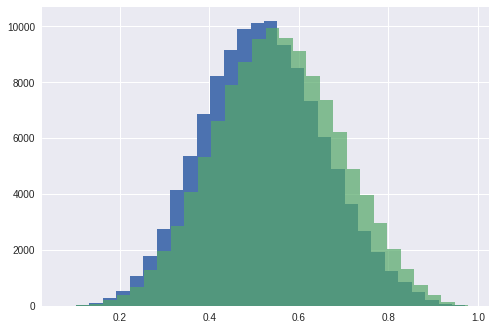

In [0]:
plt.hist(pred_res['Math test score [P086]'][pred_res_sampled['Gender [P009]_1']==1],bins=30,alpha=1)
plt.hist(pred_res['Math test score [P086]'][pred_res_sampled['Gender [P009]_2']==1],bins=30,alpha=.7)

(array([ 1020.,     0.,     0.,     0.,     0.,    44.,   174.,   439.,
          609.,   992.,  1487.,  5396.,  4092.,  4832., 11245.,  5785.,
        11151., 13685., 13200.,  9557., 10698.,  8007.,  7028.,  4447.,
         3419.,  1929.,  1255.,   702.,   612.,   310.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <a list of 30 Patch objects>)

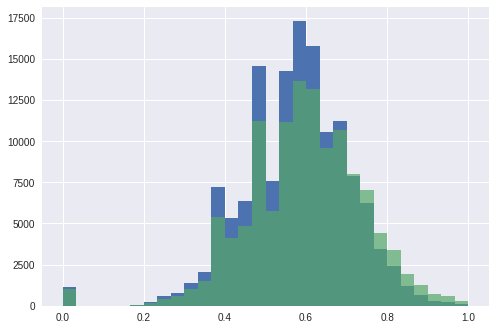

In [0]:
plt.hist(X_train_numpy['Math test score [P086]'][X_train_numpy['Gender [P009]_1']==1],bins=30,alpha=1)
plt.hist(X_train_numpy['Math test score [P086]'][X_train_numpy['Gender [P009]_2']==1],bins=30,alpha=0.7)

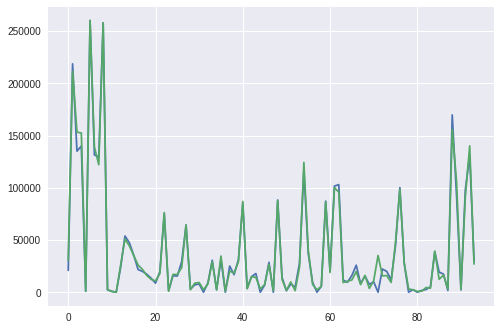

In [0]:
plt.plot(np.sum(pred_res_sampled.values,axis=0))
plt.plot(np.sum(X_train_numpy.values,axis=0))

### SQF eval

### CMP eval

In [0]:
#cat_vector
cmp_indep = eval_orig.columns.tolist()
cmp_dep = ['is_recid_1','two_year_recid_1']
[cmp_indep.remove(i) for i in cmp_dep]
tmp = np.sum(eval_gen[cmp_indep]) > 0
cmp_indep = tmp.index[tmp]

In [0]:
cmp_comp,cmp_regr_1,cmp_regr_2 = simpleLogit_comparison(eval_orig[cmp_indep],eval_orig[cmp_dep[1]],eval_gen[cmp_indep],eval_gen[cmp_dep[1]])
cmp_comp

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,0,1
age,-1.994039,-5.817805
priors_count,3.927175,6.353255
days_b_screening_arrest,1.043386,8.728571
decile_score,1.462294,1.118669
length_of_stay,0.826650,0.774950
c_charge_degree_M,-0.159138,-0.116393
race_Asian,-0.426537,-1.597405
race_Caucasian,0.025631,0.027363
race_Hispanic,-0.086662,0.038124
race_Other,-0.021547,0.282678


In [0]:
# sex_male vs sex_female

cmp_male = eval_orig['sex_Male']==1 # ~ logical not / inversion
cmp_female = ~cmp_male

gen_cmp_male = eval_gen['sex_Male']==1 
gen_cmp_female = ~gen_cmp_male

In [0]:
fpr_f,tpr_f,threshold_f = roc_curve(y_true=eval_orig[cmp_dep[0]][cmp_female],y_score=cmp_regr_1[cmp_female,1])
fpr_m,tpr_m,threshold_m = roc_curve(y_true=eval_orig[cmp_dep[0]][cmp_male],y_score=cmp_regr_1[cmp_male,1])

gen_fpr_f,gen_tpr_f,threshold_gen_f = roc_curve(y_true=eval_gen[cmp_dep[0]][gen_cmp_female],y_score=cmp_regr_2[gen_cmp_female,1])
gen_fpr_m,gen_tpr_m,threshold_gen_m = roc_curve(y_true=eval_gen[cmp_dep[0]][gen_cmp_male],y_score=cmp_regr_2[gen_cmp_male,1])

ROC curves, female blue, male green, original data left, generated on the right


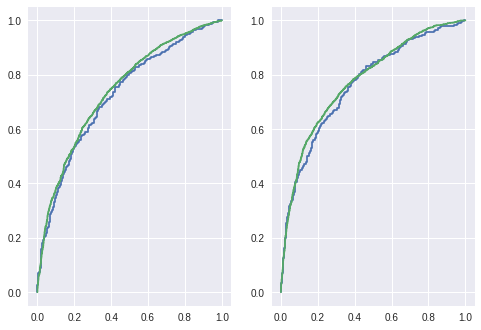

In [0]:
plt.subplot(121)
plt.plot(fpr_f,tpr_f)
plt.plot(fpr_m,tpr_m)

plt.subplot(122)
plt.plot(gen_fpr_f,gen_tpr_f)
plt.plot(gen_fpr_m,gen_tpr_m)

print('ROC curves, female blue, male green, original data left, generated on the right')

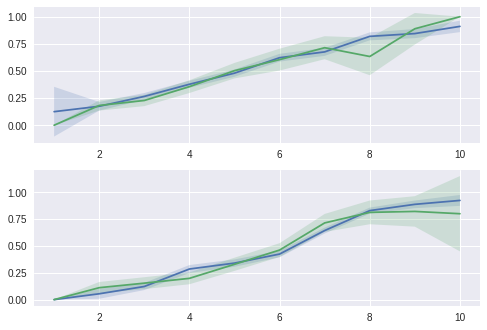

In [0]:
num_buckets = 10

plt.subplot(211)
plot_confidence(range(1,num_buckets+1),eval_orig[cmp_dep[0]][cmp_male],cmp_regr_1[cmp_male,1],num_buckets)
plot_confidence(range(1,num_buckets+1),eval_orig[cmp_dep[0]][cmp_female],cmp_regr_1[cmp_female,1],num_buckets)
plt.subplot(212)
plot_confidence(range(1,num_buckets+1),eval_gen[cmp_dep[0]][gen_cmp_male],cmp_regr_2[gen_cmp_male,1],num_buckets)
plot_confidence(range(1,num_buckets+1),eval_gen[cmp_dep[0]][gen_cmp_female],cmp_regr_2[gen_cmp_female,1],num_buckets)

### Schufa eval

In [0]:
#cat_vector
schufa_indep = eval_orig.columns.tolist()
schufa_dep = schufa_indep[-1]
schufa_indep = schufa_indep[:-1]
tmp = np.sum(eval_gen[schufa_indep]) > 0
schufa_indep = tmp.index[tmp]



In [0]:
schufa_comp,schufa_regr_1,schufa_regr_2 = simpleLogit_comparison(eval_orig[schufa_indep],eval_orig[schufa_dep],eval_gen[schufa_indep],eval_gen[schufa_dep])
schufa_comp

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,0,1
1,1.686473,2.754965
4,1.643226,1.253950
7,0.817782,1.035598
10,0.031862,0.106563
12,-0.607136,-0.932559
15,0.619429,0.330262
17,0.217918,0.528626
0_A12,-0.313413,0.025846
0_A13,-0.846331,-0.229949
0_A14,-1.598474,-1.468808


In [0]:
# Attribute 9: (qualitative) 
# Personal status and sex 
# A91 : male : divorced/separated 
# A92 : female : divorced/separated/married 
# A93 : male : single 
# A94 : male : married/widowed 
# A95 : female : single 

schufa_female = eval_orig['8_A92']==1 # | eval_orig['8_A95']==1 # second one has been removed because not generated
schufa_male = ~schufa_female # ~ logical not / inversion

gen_schufa_female = eval_gen['8_A92']==1 
gen_schufa_male = ~gen_schufa_female 

In [0]:


fpr_f,tpr_f,threshold_f = roc_curve(y_true=eval_orig[schufa_dep][schufa_female],y_score=schufa_regr_1[schufa_female,1])
fpr_m,tpr_m,threshold_m = roc_curve(y_true=eval_orig[schufa_dep][schufa_male],y_score=schufa_regr_1[schufa_male,1])

gen_fpr_f,gen_tpr_f,threshold_gen_f = roc_curve(y_true=eval_gen[schufa_dep][gen_schufa_female],y_score=schufa_regr_2[gen_schufa_female,1])
gen_fpr_m,gen_tpr_m,threshold_gen_m = roc_curve(y_true=eval_gen[schufa_dep][gen_schufa_male],y_score=schufa_regr_2[gen_schufa_male,1])

ROC curves, female blue, male green, original data left, generated on the right


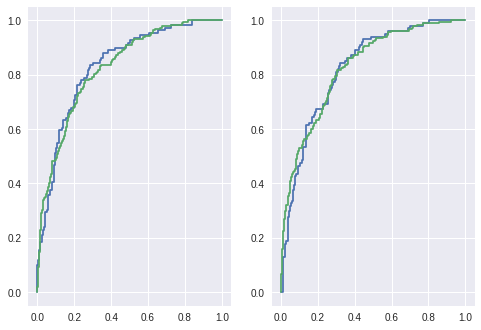

In [0]:
plt.subplot(121)
plt.plot(fpr_f,tpr_f)
plt.plot(fpr_m,tpr_m)

plt.subplot(122)
plt.plot(gen_fpr_f,gen_tpr_f)
plt.plot(gen_fpr_m,gen_tpr_m)

print('ROC curves, female blue, male green, original data left, generated on the right')

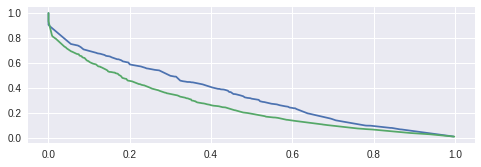

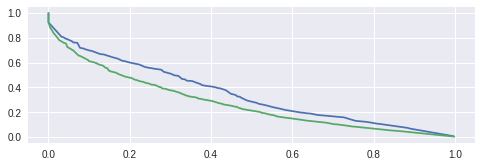

y=Positive outcome rate given x=threshold set


In [0]:
plt.subplot(211)
plot_por_vs_thresholds(schufa_regr_2[gen_schufa_female,1],schufa_regr_2[gen_schufa_male,1],threshold_gen_f,threshold_gen_m)
plt.subplot(212)
plot_por_vs_thresholds(schufa_regr_1[schufa_female,1],schufa_regr_1[schufa_male,1],threshold_f,threshold_m)
print('y=Positive outcome rate given x=threshold set')

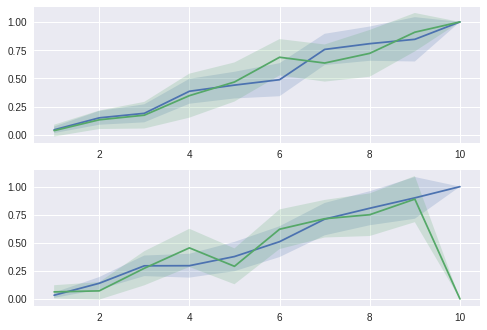

In [0]:
num_buckets = 10

plt.subplot(211)
plot_confidence(range(1,num_buckets+1),eval_orig[schufa_dep][schufa_male],schufa_regr_1[schufa_male,1],num_buckets)
plot_confidence(range(1,num_buckets+1),eval_orig[schufa_dep][schufa_female],schufa_regr_1[schufa_female,1],num_buckets)
plt.subplot(212)
plot_confidence(range(1,num_buckets+1),eval_gen[schufa_dep][gen_schufa_male],schufa_regr_2[gen_schufa_male,1],num_buckets)
plot_confidence(range(1,num_buckets+1),eval_gen[schufa_dep][gen_schufa_female],schufa_regr_2[gen_schufa_female,1],num_buckets)



# Writing a complete evaluation for one dataset

Bias soll erhalten werden:

Dokumentieren dass der bias erhalten bleibt 

*   Äquitas / nr2 (nikita)
*   Variable importance  /koeffizienten
*   Richtiges loigt model? Signifikanz (stats package), forward selection?
*   Non linear model

Wie gut kann man original rückschlüsse ziehen:
+   vorhersage der geschützten variable auf echten datensatz, nutzung der generierten daten als training
+   auch mit nicht linearer benchmark

TODO:

*   Easy way to use selected variables in logit models
*   



## Linear Models

In [0]:
from sklearn import linear_model
from sklearn.model_selection import StratifiedKFold,train_test_split
import numpy as np
import scipy.stats as stat     

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE,chi2
import scipy.stats as stat
from sklearn.linear_model import LassoCV, LogisticRegression
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families.family import Binomial
from statsmodels.discrete.discrete_model import Logit

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
#cat_vector
schufa_indep = eval_orig.columns.tolist()
schufa_dep = schufa_indep[-1]
schufa_indep = schufa_indep[:-1]
tmp = np.sum(eval_gen[schufa_indep]) > 0
schufa_indep = tmp.index[tmp]

X = eval_orig[schufa_indep]
Y = eval_orig[schufa_dep]
Xg = eval_gen[schufa_indep]
Yg = eval_gen[schufa_dep]

In [0]:
# random split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.2)
x_train_g,x_test_g,y_train_g,y_test_g = train_test_split(Xg,Yg,test_size=.2)

datasets = {'real':[x_train,x_test,y_train,y_test],'generated':[x_train_g,x_test_g,y_train_g,y_test_g]}

# stratified split
# skf = StratifiedKFold(n_splits=3)
# for train,test in skf.split(X,Y):
#   x_train, x_test = X[train],X[test]
#   y_train, y_test = Y[train],Y[test]
#   # do CV here...

In [10]:
# variable importance using extra trees:
for k,v in datasets.items():
  print('----')
  print(k,'dataset:')
  print('----')
  var_imp_model = ExtraTreesClassifier(n_estimators=100)
  var_imp_model.fit(v[0],v[2])

  print('variable importance using trees (Gini importance): ')
  print(var_imp_model.feature_importances_)

  estimator = linear_model.LogisticRegression(solver='lbfgs')
  selector = RFE(estimator)
  selector = selector.fit(v[0],v[2])

  print('RFE feature ranking and feature support:')
  print(selector.ranking_)
  print(selector.support_)

----
real dataset:
----
variable importance using trees (Gini importance): 
[0.06321239 0.06228161 0.03956349 0.03771817 0.05025475 0.02442305
 0.01660564 0.02164963 0.01596487 0.07380961 0.01432374 0.01994194
 0.01038721 0.025577   0.01416531 0.00226617 0.01812352 0.01915292
 0.00287136 0.00550187 0.00938158 0.00259807 0.01576158 0.0159013
 0.01098316 0.00837437 0.0231012  0.01671732 0.02378556 0.0198796
 0.01951465 0.02206469 0.02124874 0.01031108 0.01039739 0.01505777
 0.02204741 0.02396754 0.01679196 0.01063856 0.02574886 0.02434989
 0.00872539 0.01537148 0.02188361 0.01641037 0.02601198 0.00518065]
RFE feature ranking and feature support:
[ 1  1  1  3  1  1  9  1  1  1 13  1  1  1  1  1  6  1  7 17 25  1  5 15
  4  1  1 19 18  1 22 21  1 20 10  1 11  8  1 12  1  1  2 16 24 23 14  1]
[ True  True  True False  True  True False  True  True  True False  True
  True  True  True  True False  True False False False  True False False
 False  True  True False False  True False False  True 

In [0]:
# select features for logit model?
#x_train_selected = x_train.iloc[:,selector.support_]
#x_test_selected = x_test.iloc[:,selector.support_]

In [0]:
def get_pvalues(model): # stolen calculation :)  FROM: https://gist.github.com/rspeare
  denom = (2.0*(1.0+np.cosh(model.decision_function(X))))
  denom = np.tile(denom,(X.shape[1],1)).T
  F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
  Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
  sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
  z_scores = model.coef_[0]/sigma_estimates # z-score for each model coefficient
  p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
  return p_values

In [13]:
## different potential linear models:

model_res = {}

for k,v in datasets.items():  
  sk_logit = LogisticRegression(solver='lbfgs',C=1e9,max_iter=200) #high c -> very low additional regularization
  sk_logit.fit(v[0],v[2])
  sk_logit_res = sk_logit.predict_proba(v[1])
  print('sklearn logistic regression: ')
  print('intercept: ')
  print(sk_logit.intercept_)
  print('coefficients: ')
  print(sk_logit.coef_)
  print('p-values')
  print(get_pvalues(sk_logit))

  sk_lasso = LassoCV(cv=3)
  sk_lasso.fit(v[0],v[2])
  sk_lasso_res = sk_lasso.predict(v[1])
  print('sklearn lasso regression: ')
  print('intercept: ')
  print(sk_lasso.intercept_)
  print('coefficients: ')
  print(sk_lasso.coef_)

  sm_logit = Logit(v[2],v[0])
  sm_logit = sm_logit.fit(method='lbfgs')
  print(sm_logit.summary2())
  sm_logit_res = sm_logit.predict(v[1])

  sm_glm = GLM(v[2],v[0],family = Binomial())
  sm_glm_fitted = sm_glm.fit()
  print(sm_glm_fitted.summary2())
  sm_glm_res = sm_glm_fitted.predict(v[1])
  
  model_res[k] = [sk_logit_res[:,1],sk_lasso_res,sm_logit_res,sm_glm_res]
  

model_names = ['sk_logit','lasso','sm_logit','sm_glm']

sklearn logistic regression: 
intercept: 
[1.20094265]
coefficients: 
[[ 2.24951474  2.32650763  1.03269905  0.40343846 -1.09161091  1.06447022
   0.24653223 -0.45231899 -0.90551705 -1.71174712  0.03263079 -0.6648526
  -0.96587071 -1.70399038 -1.67143115 -1.76445666 -0.60218065 -0.92359212
  -0.5945008  -0.42017568 -0.20765594 -2.10195202 -0.67540502 -0.28447131
  -0.42202723 -1.20223329 -1.10263746 -0.13346932 -0.01840012 -1.06775244
  -0.04937989 -0.20701801 -0.87887548 -0.1030646   0.31654083 -1.0877638
   0.29629326  0.38259177  0.82442352  0.16211112 -0.74965304 -0.60959005
  -0.71196281  0.37386088  0.18459303  0.11640997 -0.16300841 -1.4507778 ]]
p-values
[0.0005489994955658908, 0.0045235944709301834, 0.00014895597732191137, 0.12842373553083086, 0.03791600197599361, 0.06628858761500557, 0.3352494587721502, 0.04158051015537261, 0.014681853616458261, 6.364928966869324e-13, 0.948824198139452, 0.08846963399488089, 0.03319264588973906, 4.0927972093655466e-05, 1.148223022195185e-05, 0

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.996      
Dependent Variable: 20_2             AIC:              1205.0355  
Date:               2019-03-04 09:24 BIC:              1429.8969  
No. Observations:   800              Log-Likelihood:   -554.52    
Df Model:           47               LL-Null:          -1.2668e+05
Df Residuals:       752              Scale:            1.0000     
Converged:          1.0000                                        
--------------------------------------------------------------------
              Coef.    Std.Err.     z      P>|z|     [0.025   0.975]
--------------------------------------------------------------------
1             0.0000     0.5773   0.0000   1.0000   -1.1315   1.1315
4             0.0000     0.7236   0.0000   1.0000   -1.4182   1.4182
7             0.0000     0.2243   0.0000   1.0000   -0.4396   0.4396
10            0.0000     0.2198   0.0000   1.0000   -0.4309   0.4309
12     

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                Results: Generalized linear model
Model:                GLM              AIC:            752.9244  
Link Function:        logit            BIC:            -4369.9036
Dependent Variable:   20_2             Log-Likelihood: -328.46   
Date:                 2019-03-04 09:24 LL-Null:        -477.17   
No. Observations:     800              Deviance:       656.92    
Df Model:             47               Pearson chi2:   779.      
Df Residuals:         752              Scale:          1.0000    
Method:               IRLS                                       
-----------------------------------------------------------------
         Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
-----------------------------------------------------------------
1         4.7417     0.8895  5.3308 0.0000      2.9983     6.4851
4         1.0926     0.9790  1.1160 0.2644     -0.8263     3.0114
7         1.1128     0.3683  3.0210 0.0025      0.3908     1.8347
10        0.2260     0.363

### per class splitting:

In [0]:
grps = {}
for k,v in datasets.items():
  # Attribute 9: (qualitative) 
  # Personal status and sex 
  # A91 : male : divorced/separated 
  # A92 : female : divorced/separated/married 
  # A93 : male : single 
  # A94 : male : married/widowed 
  # A95 : female : single 
  
  schufa_f = v[1]['8_A92']==1 # | X['8_A95']==1 # second one has been removed because not generated
  schufa_m = ~schufa_f # ~ logical not / inversion

  # age numerical variable, split into 3 parts (just by age, arbitrarly chose three parts...)
  schufa_a1 = v[1][12]<=.33
  schufa_a3 = v[1][12]>.66
  schufa_a2 = np.logical_not(np.logical_or(schufa_a1,schufa_a3))

  # TODO we could include a all true group to compare to model

  grps[k] = {'sex':{'male':schufa_m,'female':schufa_f},'age':{'age1':schufa_a1,'age2':schufa_a2,'age3':schufa_a3}}

### Accuracy

In [15]:
# Confusion matrices and acc
# for a set threshold:
threshold = .5

for k,v in datasets.items():
  print(k,'dataset accuracy and confusion matrix')
  cnt = 0
  for i in model_res[k]:
    y_p = np.round(i-threshold+.5)
    cnf_m = confusion_matrix(y_true=v[3],y_pred=y_p)
    print(model_names[cnt])
    print(cnf_m)
    print('Accuracy: ',(cnf_m[0,0]+cnf_m[1,1])/v[3].shape[0])
    cnt +=1


real dataset accuracy and confusion matrix
sk_logit
[[113  22]
 [ 38  27]]
Accuracy:  0.7
lasso
[[125  10]
 [ 50  15]]
Accuracy:  0.7
sm_logit
[[135   0]
 [ 65   0]]
Accuracy:  0.675
sm_glm
[[111  24]
 [ 38  27]]
Accuracy:  0.69
generated dataset accuracy and confusion matrix
sk_logit
[[125  20]
 [ 26  29]]
Accuracy:  0.77
lasso
[[136   9]
 [ 31  24]]
Accuracy:  0.8
sm_logit
[[124  21]
 [ 25  30]]
Accuracy:  0.77
sm_glm
[[126  19]
 [ 25  30]]
Accuracy:  0.78


### ROC

real dataset ROC curves:


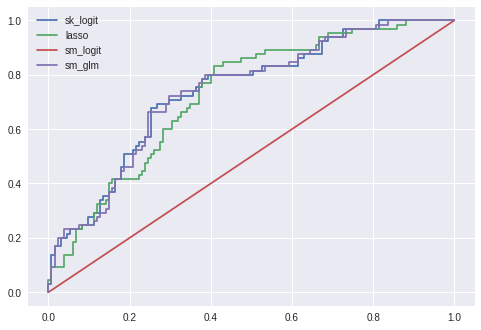

generated dataset ROC curves:


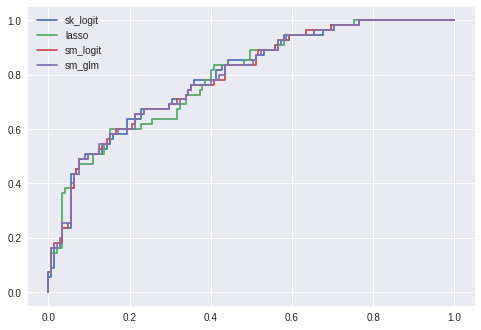

In [16]:
# GLM and logit have exact same curve but glm does not run into inf aic etc problems...
# ROC
for k,v in datasets.items():
  print(k,'dataset ROC curves:')
  cnt = 0
  for i in model_res[k]:
    fpr,tpr,thresholds = roc_curve(v[3],i)
    plt.plot(fpr,tpr,label=model_names[cnt])
    cnt +=1
  leg = plt.legend(loc='best')
  plt.show()

## Non-linear model

In [17]:
nl_model_names = ['xgboost','random forest']
nl_model_res = {}
for k,v in datasets.items():  
  # xgboost
  xgb = XGBClassifier(max_depth=3,learning_rate=1,objective='binary:logistic',n_jobs=4)
  xgb.fit(v[0],v[2])
  xgb_res = xgb.predict_proba(v[1])

  # random forest
  rf = RandomForestClassifier(n_estimators=100)
  rf.fit(v[0],v[2])
  rf_res = rf.predict_proba(v[1])
  print(k,'dataset')
  # variable importance
  print('Xgboost variable importances:')
  print(xgb.feature_importances_)

  print('Random forest variable importances:')
  print(rf.feature_importances_)

  nl_model_res[k] = [xgb_res[:,1],rf_res[:,1]]

real dataset
Xgboost variable importances:
[0.09256198 0.25785124 0.03801653 0.04132231 0.1338843  0.01818182
 0.01487603 0.01652892 0.00991736 0.02809917 0.00495868 0.01487603
 0.00495868 0.01322314 0.01157025 0.         0.01157025 0.01157025
 0.         0.         0.00330579 0.         0.00495868 0.00826446
 0.00330579 0.00495868 0.01818182 0.00991736 0.01983471 0.01157025
 0.01157025 0.00991736 0.01983471 0.         0.00330579 0.00661157
 0.0231405  0.01157025 0.00661157 0.00661157 0.01487603 0.01487603
 0.00826446 0.00826446 0.01487603 0.00826446 0.01818182 0.00495868]
Random forest variable importances:
[0.08927949 0.12115715 0.03967997 0.03742121 0.09309127 0.02378955
 0.01449649 0.01951893 0.0115331  0.0617417  0.01306578 0.01674661
 0.01175459 0.02062436 0.0132693  0.00189691 0.01828953 0.0183541
 0.00285601 0.00492121 0.00753719 0.00152294 0.01128411 0.0113733
 0.00798205 0.00684703 0.01897748 0.01457171 0.01910604 0.01380434
 0.01328093 0.01727502 0.01762813 0.00975455 0.0080

Set threshold to: 0.5
real dataset accuracy and confusion matrix
xgboost
[[113  22]
 [ 41  24]]
Accuracy:  0.685
random forest
[[126   9]
 [ 49  16]]
Accuracy:  0.71
generated dataset accuracy and confusion matrix
xgboost
[[126  19]
 [ 28  27]]
Accuracy:  0.765
random forest
[[137   8]
 [ 33  22]]
Accuracy:  0.795
real dataset ROC curves:


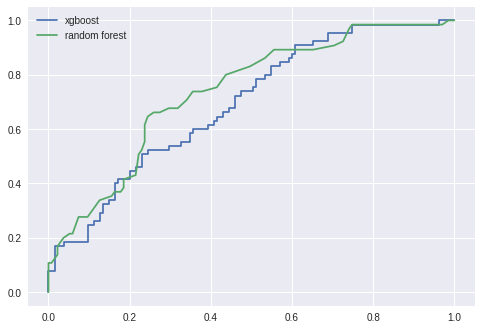

generated dataset ROC curves:


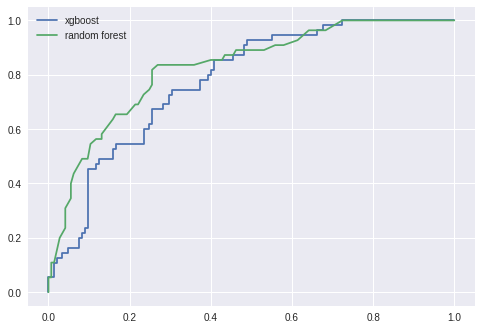

In [18]:
# Confusion matrices and acc
# for a set threshold:
threshold = .5
print('Set threshold to:',threshold)
for k,v in datasets.items():
  print(k,'dataset accuracy and confusion matrix')
  cnt = 0
  for i in nl_model_res[k]:
    y_p = np.round(i-threshold+.5)
    cnf_m = confusion_matrix(y_true=v[3],y_pred=y_p)
    print(nl_model_names[cnt])
    print(cnf_m)
    print('Accuracy: ',(cnf_m[0,0]+cnf_m[1,1])/v[3].shape[0])
    cnt +=1

# ROC
for k,v in datasets.items():
  print(k,'dataset ROC curves:')
  cnt = 0
  for i in nl_model_res[k]:
    fpr,tpr,thresholds = roc_curve(v[3],i)
    plt.plot(fpr,tpr,label=nl_model_names[cnt])
    cnt +=1
  leg = plt.legend(loc='best')
  plt.show()

## Aequitas / Nikitquitas

In [0]:
### sort such that the first group is always baseline -> i.e. set caucasian to be first group maybe?

## TODO: Check if this is working correctly by using the aequitas test dataset!
class bias_audit():
  
    def safe_divide(self,x,y):
      if y == 0:
        return 1
      return x/y

    # disparate impact
    def disp_impact(self):
      baseline_group = np.mean(self.y_hat[self.groups[0]])
      return [np.divide(np.mean(self.y_hat[i]) ,baseline_group) for i in self.groups]

    # demographic parity
    def dem_parity(self):
      baseline_group = np.mean(self.y_hat[self.groups[0]])
      return [1- np.mean(self.y_hat[i])-baseline_group for i in self.groups]

    # overall function for all rate parities:
    def rate_parity(self,v1,v2):
      fp = np.logical_and(self.y==v1, self.y_hat==v2)
      fpr1 = np.sum(np.logical_and(fp, self.groups[0]))/np.sum(np.logical_and(self.y==v1, self.groups[0]))
      return [self.safe_divide(np.sum(np.logical_and(fp, i)) / np.sum(np.logical_and(self.y==v2, i)),fpr1) for i in self.groups]

    # fpr parity
    def fpr_parity(self):
      return self.rate_parity(0,1)

    # fnr parity
    def fnr_parity(self):
      return self.rate_parity(1,0)

    # ppv parity
    def ppv_parity(self):
      return self.rate_parity(1,1)

    # npv parity
    def npv_parity(self):
      return self.rate_parity(0,0)

    # acc parity
    def acc_parity(self):
      ac1 = np.sum(self.y[self.groups[0]]==self.y_hat[self.groups[0]]) / np.sum(self.y[self.groups[0]])
      return [self.safe_divide(np.sum(self.y[i] == self.y_hat[i])/np.sum(self.y[i]),ac1) for i in self.groups]

    def create_audit(self):
      names = ['disparate impact','demographic parity','fpr parity','fnr parity','ppv parity','npv parity','accuracy parity']
      return pd.DataFrame(np.column_stack((self.disp_impact(),self.dem_parity(),
                                    self.fpr_parity(),self.fnr_parity(),
                                    self.ppv_parity(),self.npv_parity(),
                                    self.acc_parity())),columns=names)
    
    def __init__(self,y,y_hat,groups):
      self.y = y
      self.y_hat = y_hat
      self.groups = groups
      self.audit = self.create_audit()
      print(self.audit)
      
  
  

In [79]:
threshold = .5


for k,v in datasets.items():
  print(k)
  for k1,v1 in grps[k].items():
    print(k1)
    prot_values = list(grps[k][k1].keys())
    print('baseline:',prot_values[0],', compared to:',prot_values[1:])
    cnt = 0
    for y_hat in model_res[k]:
      print(model_names[cnt])
      cnt +=1
      y_hat_binary = np.round(np.array(y_hat)-threshold+.5)

      bias_audit(v[3],y_hat_binary,list(grps[k][k1].values()))

real
sex
baseline: male , compared to: ['female']
sk_logit
   disparate impact  demographic parity  fpr parity  fnr parity  ppv parity  \
0          1.000000            0.574468    2.133333     0.46875    1.000000   
1          1.513559            0.465200    2.742857     0.35809    1.546875   

   npv parity  accuracy parity  
0    1.000000         1.000000  
1    0.930582         0.964286  
lasso
   disparate impact  demographic parity  fpr parity  fnr parity  ppv parity  \
0           1.00000            0.787234    2.133333    0.468750    1.000000   
1           1.59322            0.724125    1.200000    0.364372    2.571429   

   npv parity  accuracy parity  
0    1.000000         1.000000  
1    1.034965         1.065789  
sm_logit
   disparate impact  demographic parity  fpr parity  fnr parity  ppv parity  \
0               NaN                 1.0         1.0    0.468750         1.0   
1               NaN                 1.0         1.0    0.512821         1.0   

   npv parity 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


   disparate impact  demographic parity  fpr parity  fnr parity  ppv parity  \
0          1.000000            0.557047    2.820513    0.354545    1.000000   
1          1.593583            0.425582    2.148438    0.151948    1.863971   

   npv parity  accuracy parity  
0     1.00000         1.000000  
1     1.00304         0.944257  
sm_glm
   disparate impact  demographic parity  fpr parity  fnr parity  ppv parity  \
0          1.000000            0.570470    2.820513    0.354545    1.000000   
1          1.552083            0.451902    1.833333    0.151948    1.863971   

   npv parity  accuracy parity  
0    1.000000         1.000000  
1    1.025564         0.957589  
age
baseline: age1 , compared to: ['age2', 'age3']
sk_logit
   disparate impact  demographic parity  fpr parity  fnr parity  ppv parity  \
0          1.000000            0.391304    2.709677    0.369048    1.000000   
1          0.527337            0.535158    0.913043    0.623563    0.638444   
2          0.821429   

## Predicting protected attributes

In [0]:
np.random.seed(1234)

In [0]:
from sklearn.metrics import roc_auc_score

#sex_y = eval_orig.columns  
sexes = ['8_A92','8_A93','8_A94']
sex_y_r,sex_y_g = np.int64(np.logical_not(eval_orig['8_A92']==1)),np.int64(np.logical_not(eval_gen['8_A92']==1))
sex_x_r,sex_x_g = eval_orig.drop(sexes,axis=1),eval_gen.drop(sexes,axis=1)

x_sex_r,x_t_sex_r,y_sex_r,y_t_sex_r = train_test_split(sex_x_r,sex_y_r,test_size=.2)


x_sex_g,x_t_sex_g,y_sex_g,y_t_sex_g = train_test_split(sex_x_g,sex_y_g,test_size=.2)

dsex_r = [x_sex_r,x_t_sex_r,y_sex_r,y_t_sex_r]
dsex_g = [x_sex_g,x_t_sex_g,y_sex_g,y_t_sex_g]
dsex_gr= [x_sex_g,x_t_sex_r,y_sex_g,y_t_sex_r]

In [161]:
def print_cm_auc(model,data):
  model.fit(data[0],data[2])
  print(confusion_matrix(data[3],model.predict(data[1])))  
  print('auc:',roc_auc_score(data[3],model.predict_proba(data[1])[:,1]))


print('Logistic_Regression')
print('trained on generated data, predicted generated:')
print_cm_auc(LogisticRegression(solver='lbfgs',C=1e9,max_iter=200),dsex_g)

print('trained on generated data, predicted real:')
print_cm_auc(LogisticRegression(solver='lbfgs',C=1e9,max_iter=200),dsex_gr)

print('trained on real, predicted real:')
print_cm_auc(LogisticRegression(solver='lbfgs',C=1e9,max_iter=200),dsex_r)



print('_______')
print('Random Forest')

print('trained on generated data, predicted generated:')
print_cm_auc(RandomForestClassifier(n_estimators=100),dsex_g)

print('trained on generated data, predicted real:')
print_cm_auc(RandomForestClassifier(n_estimators=100),dsex_gr)

print('trained on real, predicted real:')
print_cm_auc(RandomForestClassifier(n_estimators=100),dsex_r)



Logistic_Regression
trained on generated data, predicted generated:
[[ 18  42]
 [ 13 127]]
auc: 0.6925000000000001
trained on generated data, predicted real:
[[ 18  38]
 [ 12 132]]
auc: 0.7058531746031745
trained on real, predicted real:
[[ 18  38]
 [ 27 117]]
auc: 0.6646825396825397
_______
Random Forest
trained on generated data, predicted generated:
[[ 18  42]
 [ 10 130]]
auc: 0.8395238095238095
trained on generated data, predicted real:
[[ 32  24]
 [ 39 105]]
auc: 0.7163318452380951
trained on real, predicted real:
[[ 19  37]
 [ 14 130]]
auc: 0.7411334325396826


In [0]:
# TODO:
# SCHUFA ATTR 7+10 are not actually numerical but also categorical!!!
# SQF predict multinomial -> 10 classes!

#### AEQUITAS

#### FULL LOGIT OUTPUT mit stats package (forward selection???)
# Variable importance (mit intercept)
# Signifikanz
# Koeffizienten
# Acc?

# ROC + (PORvsScoreDecile)

#### Non-linear model mit möglichst vielen informationen
# RF /XGB, vielleicht beide?

#### Rückschlüsse auf original informationen (aka, predict orignal protected variables)
# 

# co-integration
# chi2 test

# test for comparing coeffcients